### Import libaries

In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns 
%matplotlib inline
import matplotlib.pyplot as plt
import scipy.stats as ss

### Import data

In [2]:
# Read from url - Take time to run
#url = "http://stat-computing.org/dataexpo/2009/2008.csv.bz2"
#df = pd.read_csv(url, compression='bz2')

df = pd.read_csv('./temp/Airline.csv')

In [3]:
# Reduce rows
df = df.sample(frac=0.25)

In [4]:
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,TaxiIn,TaxiOut,Cancelled,CancellationCode,Diverted,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay
2598128,2008,5,27,2,1901.0,1910,1953.0,1957,OO,5758,...,4.0,19.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
5477772,2008,10,31,5,1119.0,1030,1239.0,1155,WN,499,...,5.0,7.0,0,NaN,0,44.0,0.0,0.0,0.0,0.0
6153391,2008,11,20,4,1557.0,1602,1807.0,1748,UA,1171,...,6.0,39.0,0,NaN,0,0.0,0.0,19.0,0.0,0.0
90264,2008,1,30,3,656.0,655,818.0,820,WN,2123,...,8.0,21.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN
578954,2008,1,14,1,2209.0,2216,554.0,608,CO,234,...,5.0,10.0,0,NaN,0,NaN,NaN,NaN,NaN,NaN


Variable descriptions: http://stat-computing.org/dataexpo/2009/the-data.html

Reference: https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial

### Data pre-processing

In [5]:
df.count()

Year                 1752432
Month                1752432
DayofMonth           1752432
DayOfWeek            1752432
DepTime              1718263
CRSDepTime           1752432
ArrTime              1714467
CRSArrTime           1752432
UniqueCarrier        1752432
FlightNum            1752432
TailNum              1731691
ActualElapsedTime    1713693
CRSElapsedTime       1752215
AirTime              1713693
ArrDelay             1713693
DepDelay             1718263
Origin               1752432
Dest                 1752432
Distance             1752432
TaxiIn               1714467
TaxiOut              1718071
Cancelled            1752432
CancellationCode       34446
Diverted             1752432
CarrierDelay          381839
WeatherDelay          381839
NASDelay              381839
SecurityDelay         381839
LateAircraftDelay     381839
dtype: int64

In [6]:
#Create Date column
#df['Date'] = pd.to_datetime(df[['Year', 'Month', 'DayofMonth']])

# Drop columns
# Year: The dataset only contains data in 2008
# Cancelled + CancellationCode + Diverted: Cancelled flight does not have delay label.
df.drop(['Year', 'Cancelled', 'CancellationCode', 'Diverted'], axis=1, inplace=True)
# Delay details: Only 20% rows have these features.
df.drop(['CarrierDelay', 'WeatherDelay', 'NASDelay', 'SecurityDelay', 'LateAircraftDelay'], axis=1, inplace=True)
# Time: Only keep CRSArrTime, CRSElapsedTime
df.drop(['DepTime', 'ArrTime', 'CRSDepTime', 'ActualElapsedTime'], axis=1, inplace=True)
# Airport: Only keep the Dest Airport
df.drop(['Origin'], axis=1, inplace=True)
# Carrier: Drop FlightNum and TailNum
df.drop(['FlightNum', 'TailNum'], axis=1, inplace=True)

df.dropna(inplace=True)
df.drop_duplicates(inplace=True)

df.count()

Month             1713693
DayofMonth        1713693
DayOfWeek         1713693
CRSArrTime        1713693
UniqueCarrier     1713693
CRSElapsedTime    1713693
AirTime           1713693
ArrDelay          1713693
DepDelay          1713693
Dest              1713693
Distance          1713693
TaxiIn            1713693
TaxiOut           1713693
dtype: int64

In [7]:
# Convert CRSArrTime to Parts of the Day
conditions = [
    (df['CRSArrTime'] >= 500) & (df['CRSArrTime'] < 1201),
    (df['CRSArrTime'] >= 1201) & (df['CRSArrTime'] < 1701),
    (df['CRSArrTime'] >= 1701) & (df['CRSArrTime'] < 2101)]
choices = [1, 2, 3]
df['PotD'] = np.select(conditions, choices, default=4)

# Morning, Afternoon, Evening, Night

In [8]:
# Convert ArrDelay to Delay
# A flight only counts as late if it is more than 30 minutes late.
conditions = [
    (df['ArrDelay'] > 30)]
choices = [1]
df['Delay'] = np.select(conditions, choices, default=0)
df.drop(['CRSArrTime'], axis=1, inplace=True)

In [9]:
df.dtypes

Month               int64
DayofMonth          int64
DayOfWeek           int64
UniqueCarrier      object
CRSElapsedTime    float64
AirTime           float64
ArrDelay          float64
DepDelay          float64
Dest               object
Distance            int64
TaxiIn            float64
TaxiOut           float64
PotD                int32
Delay               int32
dtype: object

In [10]:
df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Dest,Distance,TaxiIn,TaxiOut,PotD,Delay
2598128,5,27,2,OO,47.0,29.0,-4.0,-9.0,PDX,129,4.0,19.0,3,0
5477772,10,31,5,WN,85.0,68.0,44.0,49.0,BNA,471,5.0,7.0,1,1
6153391,11,20,4,UA,106.0,85.0,19.0,-5.0,SFO,550,6.0,39.0,3,0
90264,1,30,3,WN,85.0,53.0,-2.0,1.0,DEN,391,8.0,21.0,1,0
578954,1,14,1,CO,292.0,270.0,-14.0,-7.0,EWR,2401,5.0,10.0,1,0


### Data analysis

In [11]:
#Check basic stats
df.describe()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
count,1.713693e+06,1.713693e+06,1.713693e+06,1.713693e+06,1.713693e+06,1.713693e+06,1.713693e+06,1.713693e+06,1.713693e+06,1.713693e+06,1.713693e+06,1.713693e+06
mean,6.389235e+00,1.572756e+01,3.927947e+00,1.290642e+02,1.040129e+02,8.196002e+00,9.950037e+00,7.286522e+02,6.856205e+00,1.644110e+01,2.242615e+00,1.320015e-01
std,3.398063e+00,8.800255e+00,1.988036e+00,6.953348e+01,6.744257e+01,3.850132e+01,3.522124e+01,5.631089e+02,4.924000e+00,1.130977e+01,1.019038e+00,3.384925e-01
min,1.000000e+00,1.000000e+00,1.000000e+00,-1.400000e+02,0.000000e+00,-5.190000e+02,-5.340000e+02,1.100000e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00
25%,3.000000e+00,8.000000e+00,2.000000e+00,8.000000e+01,5.500000e+01,-1.000000e+01,-4.000000e+00,3.280000e+02,4.000000e+00,1.000000e+01,1.000000e+00,0.000000e+00
50%,6.000000e+00,1.600000e+01,4.000000e+00,1.110000e+02,8.600000e+01,-2.000000e+00,-1.000000e+00,5.810000e+02,6.000000e+00,1.400000e+01,2.000000e+00,0.000000e+00
75%,9.000000e+00,2.300000e+01,6.000000e+00,1.590000e+02,1.320000e+02,1.200000e+01,8.000000e+00,9.540000e+02,8.000000e+00,1.900000e+01,3.000000e+00,0.000000e+00
max,1.200000e+01,3.100000e+01,7.000000e+00,6.600000e+02,1.091000e+03,2.453000e+03,2.467000e+03,4.962000e+03,3.080000e+02,4.290000e+02,4.000000e+00,1.000000e+00


In [12]:
#Check correlation
df.corr()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
Month,1.000000,0.000664,-0.007206,-0.006584,-0.012643,-0.041648,-0.030019,-0.005710,0.007250,-0.016537,-0.005903,-0.035043
DayofMonth,0.000664,1.000000,0.004585,0.001263,0.000659,0.001637,0.003525,0.001117,-0.002447,-0.000503,-0.001123,-0.000833
DayOfWeek,-0.007206,0.004585,1.000000,0.015327,0.014304,0.011976,0.016773,0.017131,0.009992,-0.006878,0.003494,0.011577
CRSElapsedTime,-0.006584,0.001263,0.015327,1.000000,0.988202,0.013757,0.036613,0.983183,0.103954,0.142781,0.091425,0.032540
AirTime,-0.012643,0.000659,0.014304,0.988202,1.000000,0.035689,0.028633,0.982856,0.084899,0.107702,0.078157,0.042464
ArrDelay,-0.041648,0.001637,0.011976,0.013757,0.035689,1.000000,0.931496,0.007613,0.122774,0.321662,0.114799,0.740015
DepDelay,-0.030019,0.003525,0.016773,0.036613,0.028633,0.931496,1.000000,0.027423,0.024287,0.100598,0.140731,0.686630
Distance,-0.005710,0.001117,0.017131,0.983183,0.982856,0.007613,0.027423,1.000000,0.076605,0.090879,0.091389,0.020258
TaxiIn,0.007250,-0.002447,0.009992,0.103954,0.084899,0.122774,0.024287,0.076605,1.000000,0.039784,-0.020151,0.088841
TaxiOut,-0.016537,-0.000503,-0.006878,0.142781,0.107702,0.321662,0.100598,0.090879,0.039784,1.000000,0.057332,0.289031


In [13]:
# Groupby carrier
df.groupby(['UniqueCarrier']).mean()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
UniqueCarrier,,,,,,,,,,,,
9E,6.508017,15.728467,3.946421,100.401393,71.232577,4.099532,6.699724,451.132496,8.477910,18.090715,2.191032,0.105557
AA,6.450391,15.735671,3.947108,167.580639,141.849664,12.486467,13.083757,1056.551403,8.240591,16.893094,2.322130,0.170164
AQ,1.495851,15.402490,3.944502,74.775934,61.544087,-3.131743,-1.710581,420.677386,3.815353,7.998444,2.106846,0.019191
AS,6.405286,15.659936,3.969306,155.519180,132.241314,4.838188,6.809816,964.344438,5.756202,15.549982,2.344896,0.109251
B6,6.403954,15.781965,4.002744,180.012950,150.595402,11.195398,12.630677,1102.414534,6.242023,21.740246,2.348078,0.169165
CO,6.315205,15.763528,3.915773,186.896222,156.363591,11.032407,13.214945,1158.987566,7.961458,20.388635,2.313433,0.152667
DL,6.483553,15.697038,3.920843,156.225397,126.860820,7.887170,7.974031,924.472854,8.668326,20.609390,2.248090,0.119420
EV,6.497777,15.725318,3.931518,95.618833,69.867380,10.567624,12.234906,443.630440,7.348393,16.735778,2.104059,0.152406
F9,6.459354,15.676242,3.942301,143.078063,121.387500,6.192136,5.885927,877.457740,7.399421,14.597351,2.334810,0.094950


In [14]:
# Groupby destination airport
df.groupby(['Dest']).mean()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,PotD,Delay
Dest,,,,,,,,,,,,
ABE,6.597304,15.841618,3.819714,100.085088,73.358045,8.561921,10.390901,531.133109,4.556866,20.341196,2.733783,0.140691
ABI,6.311075,15.355049,3.899023,53.216612,33.395765,8.775244,10.333876,158.000000,3.565147,14.697068,2.731270,0.138436
ABQ,6.408205,15.860846,3.961996,113.459754,91.549503,5.939583,9.065192,648.179302,5.362405,13.422237,2.277529,0.106217
ABY,6.218254,15.777778,3.829365,53.865079,27.857143,13.055556,11.888889,146.000000,3.535714,23.638889,2.400794,0.150794
ACK,7.232558,17.302326,3.984496,87.325581,46.069767,22.341085,18.961240,207.248062,5.689922,38.945736,2.116279,0.279070
ACT,6.056133,16.070686,3.910603,44.918919,23.372141,5.247401,7.282744,89.000000,4.877339,14.634096,2.191268,0.095634
ACV,6.684820,15.221321,3.894554,76.828505,56.831981,12.429896,12.091541,264.911935,4.422943,15.911935,2.449594,0.176130
ACY,2.625000,16.416667,3.625000,113.958333,88.416667,11.208333,11.708333,678.000000,3.416667,21.625000,2.833333,0.083333
ADK,6.105263,13.473684,5.578947,187.947368,174.052632,7.210526,3.210526,1192.000000,4.947368,12.947368,2.578947,0.105263


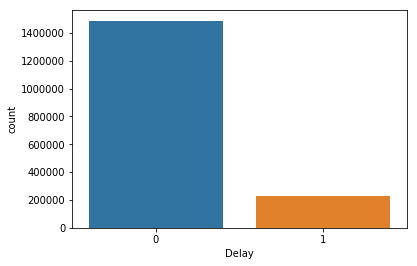

In [15]:
# Bias check
sns.countplot(x="Delay", data=df)

In [16]:
# Check Correlation
def cramers_corrected_stat(x, y):

    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    result=-1
    if len(x.value_counts())==1 :
        print("First variable is constant")
    elif len(y.value_counts())==1:
        print("Second variable is constant")
    else:   
        conf_matrix=pd.crosstab(x, y)

        if conf_matrix.shape[0]==2:
            correct=False
        else:
            correct=True

        chi2 = ss.chi2_contingency(conf_matrix, correction=correct)[0]

        n = sum(conf_matrix.sum())
        phi2 = chi2/n
        r,k = conf_matrix.shape
        phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
        rcorr = r - ((r-1)**2)/(n-1)
        kcorr = k - ((k-1)**2)/(n-1)
        result=np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))
    return round(result,6)

#### Month

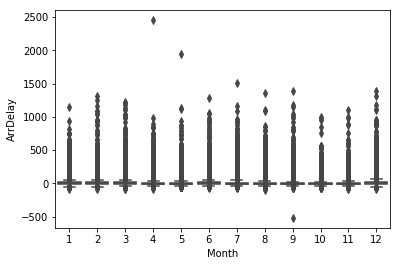

In [17]:
sns.boxplot(x='Month', y='ArrDelay', data=df) #x is feature, y is target

In [18]:
cramers_corrected_stat(df['Delay'], df['Month'])

0.119243

#### DayofMonth

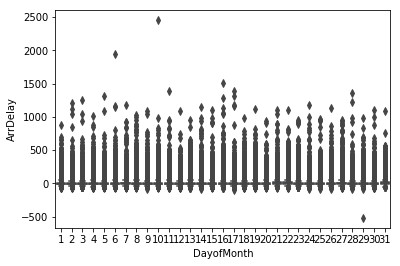

In [ ]:
sns.boxplot(x='DayofMonth', y='ArrDelay', data=df) #x is feature, y is target

In [ ]:
cramers_corrected_stat(df['Delay'], df['DayofMonth'])

0.03545

#### Weekend

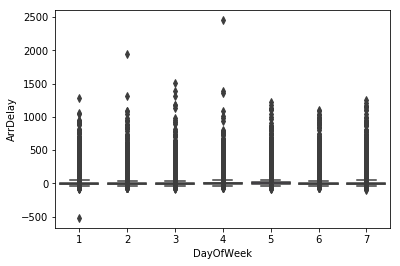

In [ ]:
sns.boxplot(x='DayOfWeek', y='ArrDelay', data=df) #x is feature, y is target

In [ ]:
cramers_corrected_stat(df['Delay'], df['DayOfWeek'])

0.037981

#### Parts of the Day

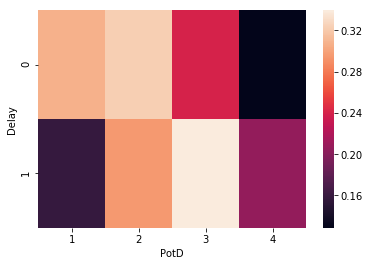

In [ ]:
sns.heatmap(pd.crosstab(df['Delay'], df['PotD'], normalize='index'))

In [ ]:
cramers_corrected_stat(df['Delay'], df['PotD'])

0.136265

### Encoding

In [ ]:
# Apply One-hot encoding to Dest column

df = pd.concat([df, pd.get_dummies(df['Dest'], prefix='Dest',dummy_na=True)],axis=1).drop(['Dest'],axis=1)

In [ ]:
# Apply One-hot encoding to UniqueCarrier column

df = pd.concat([df, pd.get_dummies(df['UniqueCarrier'], prefix='UniqueCarrier',dummy_na=True)],axis=1).drop(['UniqueCarrier'],axis=1)

In [ ]:
df.head()

,Month,DayofMonth,DayOfWeek,CRSElapsedTime,AirTime,ArrDelay,DepDelay,Distance,TaxiIn,TaxiOut,...,UniqueCarrier_MQ,UniqueCarrier_NW,UniqueCarrier_OH,UniqueCarrier_OO,UniqueCarrier_UA,UniqueCarrier_US,UniqueCarrier_WN,UniqueCarrier_XE,UniqueCarrier_YV,UniqueCarrier_nan
2598128,5,27,2,47.0,29.0,-4.0,-9.0,129,4.0,19.0,...,0,0,0,1,0,0,0,0,0,0
5477772,10,31,5,85.0,68.0,44.0,49.0,471,5.0,7.0,...,0,0,0,0,0,0,1,0,0,0
6153391,11,20,4,106.0,85.0,19.0,-5.0,550,6.0,39.0,...,0,0,0,0,1,0,0,0,0,0
90264,1,30,3,85.0,53.0,-2.0,1.0,391,8.0,21.0,...,0,0,0,0,0,0,1,0,0,0
578954,1,14,1,292.0,270.0,-14.0,-7.0,2401,5.0,10.0,...,0,0,0,0,0,0,0,0,0,0


### Model evaluation

In [ ]:
# Why?
# Airline:
# Dest Airport + CRSArrTime: 
# Departure features:


X_data = df.drop(['Delay', 'ArrDelay'], axis=1)
y_data = df['Delay']

# Holdout
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.2, random_state=0)

#### Features engineering

##### Dimension reduction using PCA

In [ ]:
#Standar Scaler

from sklearn.preprocessing import StandardScaler

numeric_features = ['Month', 'DayofMonth', 'DayOfWeek', 'CRSElapsedTime', 'AirTime', 'DepDelay', 'Distance', 'TaxiIn', 'TaxiOut', 'PotD']
X_train_numeric = X_train[numeric_features]
X_test_numeric = X_test[numeric_features]


# Fit on training set only.
scaler = StandardScaler().fit(X_train_numeric)


    
# Apply transform to both the training set and the test set.
X_train_numeric = scaler.transform(X_train_numeric)
X_test_numeric = scaler.transform(X_test_numeric)

#PCA
from sklearn.decomposition import PCA

# Fit on training set only.
pca = PCA(n_components=1).fit(X_train_numeric)

# Apply transform to both the training set and the test set.
X_train.insert(0, 'PCA', pca.transform(X_train_numeric))
X_test.insert(0, 'PCA', pca.transform(X_test_numeric))
#X_train['PCA'] = pca.transform(X_train_numeric)
#X_test['PCA'] = pca.transform(X_test_numeric)

X_train.drop(numeric_features, axis = 1, inplace = True)
X_test.drop(numeric_features, axis = 1, inplace= True)

In [ ]:
X_train.head()

##### Features selection using RFE

In [ ]:
# RFE
from sklearn.feature_selection import RFE

from sklearn.linear_model import LogisticRegression
model = LogisticRegression()
rfe = RFE(estimator = model, n_features_to_select = 10, step = 5)

We will use F1 score as the evaluation metric. Our target value is binary so it’s a binary classification problem, and out data is inbalance, so in this case F1 score is a good way for evaluation for this type of problems.

#### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB
model = GaussianNB()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [ ]:
# Metrics
# https://medium.com/thalus-ai/performance-metrics-for-classification-problems-in-machine-learning-part-i-b085d432082b
# Confusion Matrix
from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

[[178136 119498]
 [  5388  39717]]
              precision    recall  f1-score   support

           0       0.97      0.60      0.74    297634
           1       0.25      0.88      0.39     45105

   micro avg       0.64      0.64      0.64    342739
   macro avg       0.61      0.74      0.56    342739
weighted avg       0.88      0.64      0.69    342739



#### Logistic Regression using GridSearchCV

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

grid = {'C' : [1, 5, 10]}

model_cv = GridSearchCV(estimator = LogisticRegression(), 
                        param_grid = grid, cv = 3, scoring = 'f1', n_jobs = -1)

model_cv.fit(X_data, y_data)

print("tuned hpyerparameters :(best parameters) ",model_cv.best_params_)
print("accuracy :",model_cv.best_score_)

Tune hyper parameters using 3-values-method, with f1 metric.

#### Gradient Boosting
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-gradient-boosting-3363992e9bae

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

In [ ]:
# Metrics
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred)
f1

In [ ]:
learning_rates = [1, 0.5, 0.25, 0.1, 0.05, 0.01]
test_results = []
for learning_rate in learning_rates:
    model = GradientBoostingClassifier(learning_rate = learning_rate)
    model.fit(X_train, y_train)
  
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
    
    print(learning_rate, ' done!')
    
# Plot metrics line chart
sns.lineplot(x = n_estimators, y = test_results)

In [ ]:
# n_estimators
n_estimators = [1, 5, 10, 15, 20, 25, 50]
test_results = []
for estimator in n_estimators:
    model = GradientBoostingClassifier(n_estimators = estimator)
    model.fit(X_train, y_train)
  
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
    
    print(estimator, ' done!')
    
# Plot metrics line chart
sns.lineplot(x = n_estimators, y = test_results)

In [ ]:
# max_depths
max_depths = np.linspace(5, 35, 7)
test_results = []

for max_depth in max_depths:
    model = GradientBoostingClassifier(max_depth = max_depth)
    model.fit(X_train, y_train)
  
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
    
    print(max_depth, ' done!')

# Plot metrics line chart
sns.lineplot(x = max_depths, y = test_results)

Best parameters:
- learning_rate = 
- n_estimators = 
- max_depths = 

In [ ]:
model = GradientBoostingClassifier(learning_rate = , n_estimators = , max_depth = )
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

#### Random Forest
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-random-forest-d67bb7e920d

In [ ]:
# Default parameters
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_jobs = -1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


In [ ]:
# Metrics
from sklearn.metrics import f1_score

f1 = f1_score(y_test, y_pred)
f1

0.8794160377024202

1  done!
5  done!
10  done!
15  done!
20  done!
25  done!
50  done!


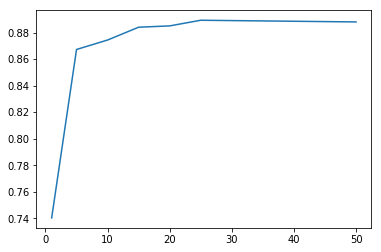

In [ ]:
# n_estimators
n_estimators = [1, 5, 10, 15, 20, 25, 50]
test_results = []
for estimator in n_estimators:
    model = RandomForestClassifier(n_estimators = estimator, n_jobs = -1)
    model.fit(X_train, y_train)
  
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
    
    print(estimator, ' done!')
    
# Plot metrics line chart
sns.lineplot(x = n_estimators, y = test_results)

C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


5.0  done!


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


10.0  done!


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


15.0  done!


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


20.0  done!


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


25.0  done!


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


30.0  done!


C:\Users\Admin\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


35.0  done!


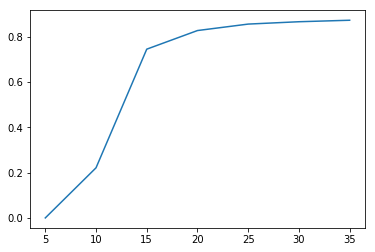

In [ ]:
# max_depths
max_depths = np.linspace(5, 35, 7)
test_results = []

for max_depth in max_depths:
    model = RandomForestClassifier(max_depth = max_depth, n_jobs = -1)
    model.fit(X_train, y_train)
  
    y_pred = model.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    test_results.append(f1)
    
    print(max_depth, ' done!')

# Plot metrics line chart
sns.lineplot(x = max_depths, y = test_results)

Best parameters:
- n_estimators = 15
- max_depths = 20

In [ ]:
model = RandomForestClassifier(n_estimators = 15, max_depth = 20, n_jobs = -1)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Report
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98    297634
           1       0.93      0.78      0.85     45105

   micro avg       0.96      0.96      0.96    342739
   macro avg       0.95      0.89      0.91    342739
weighted avg       0.96      0.96      0.96    342739



#### SVC
https://medium.com/all-things-ai/in-depth-parameter-tuning-for-svc-758215394769


# TODO

1. Edit threshhold / class weight
2. PCA: Dimension reducing
3. RFE: Features selection
4. GridsearchCV for tuning
- Tuning with 3 values
- Goal: Precison ~ Recall (F1 score)
5. Compare performances among models